# Modelos aplicando MLFlow

In [1]:
# Importar librería para cargar datos procesados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importar modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Importar funciones para el entrenamiento y validación de los modelos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve

#Importa MLFLOW
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import json



## Carga de datos

In [2]:
# Datos de entrenamiento
X_train = pd.read_parquet('../../../data/processed/X_train.parquet')
y_train = pd.read_parquet('../../../data/processed/y_train.parquet')

# Datos de prueba
X_test = pd.read_parquet('../../../data/processed/X_test.parquet')
y_test= pd.read_parquet('../../../data/processed/y_test.parquet')

In [3]:
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test: ',X_test.shape)
print('y_test: ',y_test.shape)

X_train: (940754, 44)
y_train: (940754, 1)
X_test:  (235189, 44)
y_test:  (235189, 1)


## MLFLOW

In [4]:
track_uri = "http://localhost:8080/" # Esto puede ser que cambie por http://0.0.0.0:1234
mlflow.set_tracking_uri(track_uri)
mlflow.set_registry_uri("sqlite:////tmp/registry.db")

In [5]:
# Generando el experimento o cargandolo si existe
experiment_name = "ML_COVID19-MEXICO"
mlflow.set_experiment(experiment_name)

# Cargando la información
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Validacion
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 2.13.0
Tracking URI: http://localhost:8080/
Nombre del experimento: ML_COVID19-MEXICO
ID del experimento: 707578369122819239


# Modelos

In [6]:
fecha = '20240526'

## Regresion Logistica

### Version Sencilla

C:\Users\vesna\miniconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vesna\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vesna\miniconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


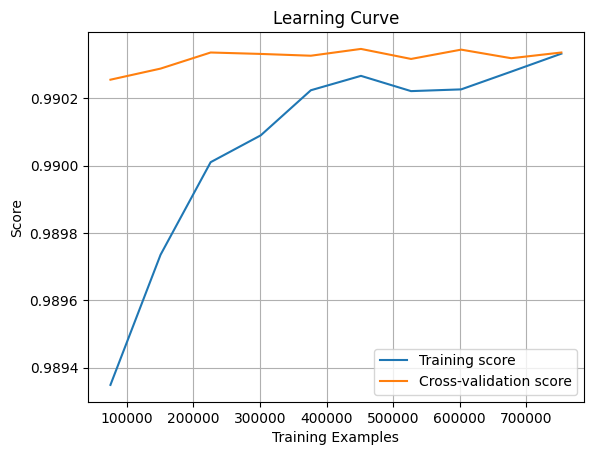

In [7]:
name = "Logistic Regression_"+fecha+"_Simple_1000ep"

# Inicializa el modelo de Regresión Logística
log_regression = LogisticRegression(max_iter=1000)

# Iniciar un nuevo experimento en MLflow
with mlflow.start_run(run_name=name):
    # Entrena el modelo en los datos de entrenamiento
    log_regression.fit(X_train, y_train)

    # Realiza predicciones en el conjunto de prueba
    y_pred = log_regression.predict(X_test)
    y_prob = log_regression.predict_proba(X_test)[:, 1]

    # Evalúa el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    # Registrar las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Registrar la matriz de confusión como artefacto
    with open("confusion_matrix-"+name+".txt", "w") as f:
        f.write(str(conf_matrix))
    mlflow.log_artifact("confusion_matrix-"+name+".txt")

    # Registrar el informe de clasificación como artefacto
    with open("classification_report-"+name+".json", "w") as f:
        json.dump(classification_rep, f)
    mlflow.log_artifact("classification_report-"+name+".json")

    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(log_regression, "model-"+name)

    # Generar y registrar la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(log_regression, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")
    
    
# Finaliza la ejecución
mlflow.end_run()

### Ajuste de hiperparamentros

In [ ]:
name = "Logistic Regression-GridSearchCV_"+fecha

# Definir la cuadrícula de hiperparámetros a ajustar
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear']  # 'liblinear' supports l1 penalty
}

# Inicia una nueva ejecución en MLflow
with mlflow.start_run(run_name=name):
    # Inicializar el modelo de Regresión Logística
    log_regression = LogisticRegression()

    # Inicializar GridSearchCV
    grid_search = GridSearchCV(log_regression, param_grid, cv=5, scoring='accuracy')

    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Mejores hiperparámetros
    best_params = grid_search.best_params_

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Evaluar el mejor modelo en los datos de prueba
    y_pred_best_model = best_model.predict(X_test)
    y_prob_best_model = best_model.predict_proba(X_test)[:, 1]

    # Accuracy del mejor modelo
    accuracy_best_model = accuracy_score(y_test, y_pred_best_model)
    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model, output_dict=True)
    # Registra los hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_best_model)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(best_model, "model_"+name)

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix-"+name+".png")
    mlflow.log_artifact("confusion_matrix-"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")


# Finaliza la ejecución
mlflow.end_run()

C:\Users\vesna\miniconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vesna\miniconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vesna\miniconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vesna\miniconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

## Decision Tree

### Version Sencilla

In [ ]:
name = "Decision Tree_Simple_"+fecha


with mlflow.start_run(run_name=name):
    # Inicializar el modelo de árbol de decisión con los hiperparámetros especificados
    decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=1000)

    # Entrenar el modelo en los datos de entrenamiento
    decision_tree.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = decision_tree.predict(X_test)
    y_prob = decision_tree.predict_proba(X_test)[:, 1]

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    # Registra los hiperparámetros en MLflow
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 100)
    mlflow.log_param("min_samples_leaf", 1000)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(decision_tree, "model-"+name)

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix-"+name+".png")
    mlflow.log_artifact("confusion_matrix-"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(decision_tree, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")


# Finaliza la ejecución
mlflow.end_run()


### Ajuste de hiperparametros

In [ ]:
name = "Decision Tree-GridSearchCV_"+fecha

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Inicializar el modelo de árbol de decisión
decision_tree = DecisionTreeClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

# Inicia una nueva ejecución en MLflow
name = "Decision Tree Grid Search with Learning Curve and ROC"
with mlflow.start_run(run_name=name):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)
    y_prob_best_model = best_model.predict_proba(X_test)[:, 1]

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    classification_rep_best_model = classification_report(y_test, y_pred_best_model, output_dict=True)

    # Registra los hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(best_model, "model-"+name)

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix-"+name+".png")
    mlflow.log_artifact("confusion_matrix-"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")



# Finaliza la ejecución
mlflow.end_run()

## Support Vector Machine

### Version Sencilla

In [ ]:
name = "Random Forest_Simple_"+fecha

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=4
)

# Inicia una nueva ejecución en MLflow
with mlflow.start_run(run_name=name):
    # Entrenar el modelo
    rf_classifier.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = rf_classifier.predict(X_test)
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    # Registra los hiperparámetros en MLflow
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 10)
    mlflow.log_param("min_samples_leaf", 4)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(rf_classifier, "model-"+name)

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix-"+name+".png")
    mlflow.log_artifact("confusion_matrix-"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(rf_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")


# Finaliza la ejecución
mlflow.end_run()

### Ajuste de hiperparametros

In [ ]:
name = "Random Forest_Grid Search_"+fecha

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Inicializar la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Inicia una nueva ejecución en MLflow
with mlflow.start_run(run_name=name):
    # Entrenar el modelo utilizando la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Mejores hiperparámetros
    best_params = grid_search.best_params_

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_rf_classifier = grid_search.best_estimator_

    # Predecir en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_rf_classifier.predict(X_test)
    y_prob_best_model = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Accuracy del mejor modelo
    accuracy_best_model = accuracy_score(y_test, y_pred_best_model)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model, output_dict=True)

    # Registra los hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Registra las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_best_model)

    # Guarda el modelo en MLflow
    mlflow.sklearn.log_model(best_rf_classifier, "model-"+name)

    # Guarda la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix-"+name+".png")
    mlflow.log_artifact("confusion_matrix-"+name+".png")

    # Genera los datos para la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_rf_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    # Calcula los promedios y desviaciones estándar de los puntajes de entrenamiento y prueba
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Grafica la curva de aprendizaje
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")


# Finaliza la ejecución
mlflow.end_run()

## Random Forest Classifier

### Version Sencilla

### Ajuste de hiperparametros

## Gradient Boosting

### Version Sencilla

In [ ]:
name = "GradientBoostingClassifier_Simple_"+fecha

# Inicializar el modelo de Gradient Boosting
gradient_boosting = GradientBoostingClassifier()

# Iniciar un nuevo experimento en MLflow
with mlflow.start_run(run_name=name):
    # Entrenar el modelo en los datos de entrenamiento
    gradient_boosting.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = gradient_boosting.predict(X_test)
    y_prob = gradient_boosting.predict_proba(X_test)[:, 1]
    
    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    # Registrar las métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)
    
    # Registrar la matriz de confusión como artefacto
    with open("confusion_matrix-"+name+".txt", "w") as f:
        f.write(str(conf_matrix))
    mlflow.log_artifact("confusion_matrix-"+name+".txt")
    
    # Registrar el informe de clasificación como artefacto
    with open("classification_report-"+name+".json", "w") as f:
        json.dump(classification_rep, f)
    mlflow.log_artifact("classification_report-"+name+".json")
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(gradient_boosting, "model-"+name)
    
    # Generar y registrar la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(gradient_boosting, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")
    

# Finalizar la ejecución
mlflow.end_run()

### Ajuste de hiperparametros

In [ ]:
name = "GradientBoosting-GridSearchCV_"+fecha

# Definir la cuadrícula de hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el modelo de Gradient Boosting
gradient_boosting = GradientBoostingClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(gradient_boosting, param_grid, cv=5, scoring='accuracy')

# Iniciar un nuevo experimento en MLflow
with mlflow.start_run(run_name=name):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    
    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)
    print("Mejores hiperparámetros:", best_params)
    
    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_rf_classifier = grid_search.best_estimator_

    # Predecir en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_rf_classifier.predict(X_test)
    y_prob_best_model = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Accuracy del mejor modelo
    accuracy_best_model = accuracy_score(y_test, y_pred_best_model)
    mlflow.log_metric("accuracy", accuracy_best_model)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    with open("confusion_matrix-"+name+".txt", "w") as f:
        f.write(str(conf_matrix_best_model))
    mlflow.log_artifact("confusion_matrix-"+name+".txt")

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model, output_dict=True)
    with open("classification_report-"+name+".json", "w") as f:
        json.dump(classification_rep_best_model, f)
    mlflow.log_artifact("classification_report-"+name+".json")

    # Generar y registrar la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_rf_classifier, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig("learning_curve-"+name+".png")
    mlflow.log_artifact("learning_curve-"+name+".png")

# Finalizar la ejecución
mlflow.end_run()